# Linear Prediction: A Tutorial Review
### John Makhoul


I think this demonstration will go through the steps of LPC analysis \
https://www.mathworks.com/help/signal/ug/formant-estimation-with-lpc-coefficients.html

Here is an overview of the steps we will follow:
1. Window the signal
2. Apply pre-emphasis
3. Compute coefficients (autocorrelation)
4. Compute frequency response


In [38]:
using DSP
using WAV
using Plots
using Random
using FFTW

In [39]:
# I will set all parameters in this cell
window_size = 400
overlap = 100
order = 10
# n_freqs = 22100

10

In [40]:
# Load the file
signal, fs, b, opt = wavread("demo_data/aa_audio/audio_lpc_aa_fo160.wav")
# signal, fs, b, opt = wavread("demo_data/test.wav")

([0.0; 0.0; … ; -3.051850947599719e-5; 0.0;;], 44100.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x44, 0xac, 0x00, 0x00, 0x88, 0x58, 0x01, 0x00, 0x02, 0x00, 0x10, 0x00])])

In [41]:
# Here is the same function for Hanning windows that I used in the spectrogram code
function hanning(size)
    # where size refers to the window length
    return 0.5 * (1 .- cos.(2π * (0:size-1) ./ (size-1)))
end

hanning (generic function with 1 method)

In [42]:
# Fuction for performing autocorrelation
# Autocorrelation is basically a mathematical way of looking for repeating patterns in the signal
# The function returns an array of autocorrelation values of length = order
function autocorrelation(signal::Array{Float64}, p_order::Int64)::Array{Float64}
    N = length(signal)
    r = zeros(Float64, p_order + 1)
    for k in 0:p_order # for every lag in order
        r[k + 1] = sum(signal[1:N - k] .* signal[1 + k:N]) # sum the product of two different sections of the signal
    end
    return r
end

autocorrelation (generic function with 1 method)

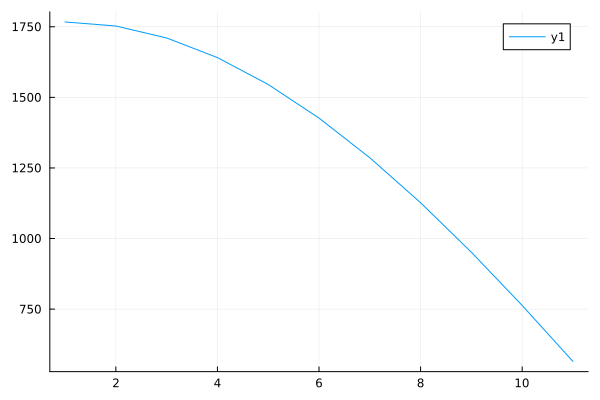

In [43]:
# Test
# ac = []
# for window in windows
#     push!(ac, autocorrelation(window, order))
# end
ac = autocorrelation(signal, order)
plot(ac)

In [44]:
# Compute coefficients
# Durbin's recursive method to solve Yule-Walker equations for LPC coefficients
function durbin(r, p_order)
    a = zeros(Float64, p_order)
    E = r[1]
    
    for i in 1:p_order
        acc = 0.0
        for j in 1:i-1
            acc += a[j] * r[i - j + 1]
        end
        k = (r[i + 1] - acc) / E  # Reflection coefficient
        
        a_new = copy(a)
        for j in 1:i-1
            a_new[j] = a[j] - k * a[i - j]
        end
        a_new[i] = k
        
        a = a_new
        E = E * (1 - k^2)
    end
    
    return [1.0; -a]  # LPC coefficients with a[0] = 1
end

durbin (generic function with 1 method)

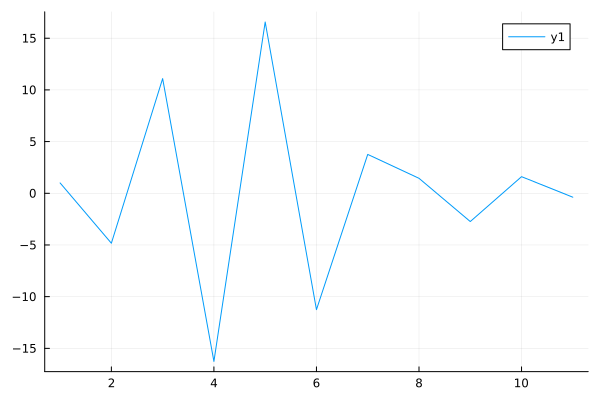

In [45]:
# # Test
coefficients = durbin(ac, order)
# println(coefficients)
plot(coefficients)

In [46]:
# Step 3: Compute frequency response from LPC coefficients
n_freqs = Int(round(fs/2))
f = range(0, stop=fs/2, length=n_freqs)
freq_response = zeros(ComplexF64, n_freqs)

for i in 1:n_freqs
    omega = 2π*f[i]/fs # Convert frequency to angular frequency (radians per second)
    z = exp(-1im * omega) # Represent the frequency as a complex exponential
    freq_response[i] = 1 / sum(coefficients .* z.^(0:order)) # Calculate the frequency response
end

mag_response = abs.(freq_response)

22050-element Vector{Float64}:
 1068.3766057660291
 1068.3761975944192
 1068.374973134494
 1068.3729325096383
 1068.3700759549924
 1068.3664037925635
 1068.361916422671
 1068.3566143607354
 1068.350498182327
 1068.3435685719223
    ⋮
    0.017060995467438042
    0.017060996954762393
    0.01706099824378556
    0.017060999334503796
    0.017061000226913935
    0.0170610009210134
    0.017061001416800163
    0.017061001714272803
    0.01706100181343044

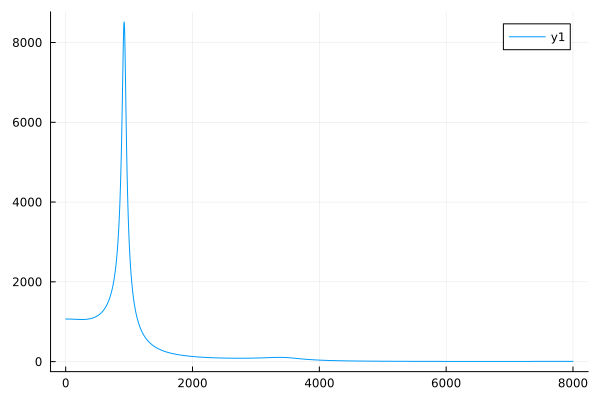

In [47]:
# Test
plot(mag_response[1:8000])

In [48]:
    # Step 4: Identify formant frequencies (peaks in magnitude response)
    peak_indices = findall(x -> x > 0.05, diff(signbit.(diff(mag_response))))  # Find peaks
    formant_frequencies = f[peak_indices]
    println(formant_frequencies)

Float32[919.0417, 3367.1526, 7943.3604, 10621.481]


### Windowed

In [49]:
using DSP
using WAV
using Plots
using Random
using FFTW

In [50]:
# signal, fs, b, opt = wavread("demo_data/aa_audio/audio_lpc_aa_fo100.wav")
signal, fs, b, opt = wavread("demo_data/aa_audio/audio_lpc_aa_fo160.wav")
# signal, fs, b, opt = wavread("demo_data/aa_audio/audio_lpc_aa_fo300.wav")
# signal, fs, b, opt = wavread("demo_data/test.wav")

([0.0; 0.0; … ; -3.051850947599719e-5; 0.0;;], 44100.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x44, 0xac, 0x00, 0x00, 0x88, 0x58, 0x01, 0x00, 0x02, 0x00, 0x10, 0x00])])

In [51]:
# Window the signal
num_windows = div(length(signal) - window_size, window_size - overlap) + 1
windows = []

for i in 1:num_windows
    start_idx = (i - 1) * (window_size - overlap) + 1
    end_idx = start_idx + window_size - 1
    window = signal[start_idx:end_idx]
    windowed_signal = window .* hanning(window_size)
    push!(windows, windowed_signal)
end

In [52]:
f1 = []
f2 = []
window_size = 400
overlap = 100
order = 30
n_freqs = 300
formant_max = 3000

3000

In [53]:
for window in windows
    ac = autocorrelation(window, order)
    coefficients = durbin(ac, order)
    # n_freqs = Int(round(fs/2))
    # n_freqs = 4000
    f = range(0, stop=formant_max, length=n_freqs)
    freq_response = zeros(ComplexF64, n_freqs)
    
    for i in 1:n_freqs
        omega = 2π*f[i]/fs # Convert frequency to angular frequency (radians per second)
        z = exp(-1im * omega) # Represent the frequency as a complex exponential
        freq_response[i] = 1 / sum(coefficients .* z.^(0:order)) # Calculate the frequency response
    end
    
    mag_response = abs.(freq_response)
    peak_indices = findall(x -> x > 0.05, diff(signbit.(diff(mag_response))))  # Find peaks
    formant_frequencies = f[peak_indices]
    if (length(formant_frequencies) > 1)
        push!(f1, formant_frequencies[1])
        push!(f2, formant_frequencies[2])
    else
        push!(f1, 0)
        push!(f2, 0)
    end
end
# println(peaks)

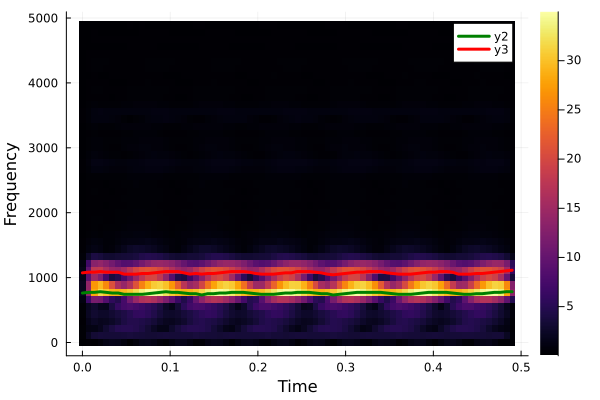

In [54]:
# signal, fs, b, opt = wavread("demo_data/aa_audio/audio_lpc_aa_fo160.wav")

# Parameters for spectrogram
# window_size = 400
# overlap = 100

function compute_spectrogram(signal, window_size, overlap)
    num_windows = div(length(signal) - window_size, window_size - overlap) + 1
    spectrogram = []

    for i in 1:num_windows
        start_idx = (i - 1) * (window_size - overlap) + 1
        end_idx = start_idx + window_size - 1
        window = signal[start_idx:end_idx]
        windowed_signal = window .* hanning(window_size)
        spectrum = abs.(fft(windowed_signal)[1:div(window_size,2)])
        push!(spectrogram, spectrum)
    end

    return hcat(spectrogram...), num_windows
end

function hanning(size)
    return 0.5 * (1 .- cos.(2π * (0:size-1) ./ (size-1)))
end

spectrogram, num_windows = compute_spectrogram(signal, window_size, overlap)

n_samp = length(signal)
time_step = (window_size - overlap) / fs
t = 0:time_step:time_step * (num_windows - 1)  # Time vector

# Define the maximum frequency you want to display
fc = 5000 # in Hz

# Convert fc to corresponding matrix index
max_index = Int(round(fc * size(spectrogram, 1) / (fs / 2)))

# Slice the spectrogram matrix to keep only the lower frequencies
spectrogram = spectrogram[1:max_index, :]

f = 1:fc/size(spectrogram, 1):fc

heatmap(t, f, spectrogram, xlabel="Time", ylabel="Frequency")
plot!(t, f1, linecolor="green", linewidth=3)
plot!(t, f2, linecolor="red", linewidth=3)

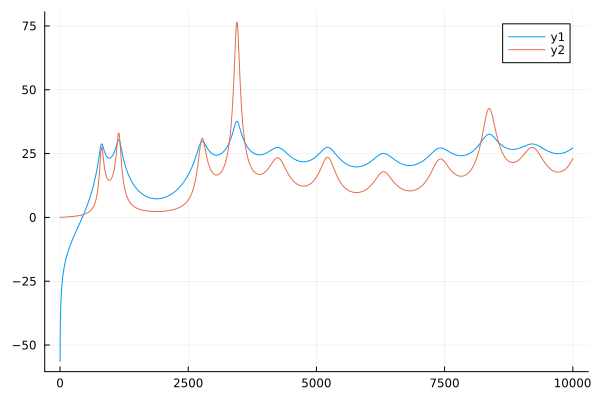

In [55]:
f = open("demo_data/FreqResponse_aa.txt")
resp1 = []
resp2 = []
resp3 = []
lines = readlines(f)
for line in lines
    row = split(line, "\t")
    parsed_row = []
    for item in row
        parsed = parse(Float64, item)
        push!(parsed_row, parsed)
    end
    push!(resp1, parsed_row[1])
    push!(resp2, parsed_row[2])
    push!(resp3, parsed_row[3])
end
  plot(resp1, resp2)
  plot!(resp1, resp3)